# Deep Learning for Cone Cells and Light Frequency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

import pickle

from simulator_lib import *

2025-04-25 14:50:02.959317: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 14:50:03.089219: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-25 14:50:03.228331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745607003.369058   13601 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745607003.405205   13601 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 14:50:03.691278: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Generating / Loading the Cone Cells

In [2]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/normal_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            eyes.append(cone_cells)

## Generating the Simulation Data

In [3]:
NUM_DATA_POINTS = 1000

activations = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS, len(eyes[0])))
colors = np.zeros(shape=(len(eyes) * NUM_DATA_POINTS))

for i, cone_cells in enumerate(eyes):
    a, c = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    c = np.array(c).astype(int)

    activations[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = a
    colors[i * NUM_DATA_POINTS : (i+1) * NUM_DATA_POINTS] = c

print(activations)
print(colors)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
[2. 1. 3. ... 1. 3. 3.]


## Feedforward Network Architecture

### Separate Data into Training and Test Sets

In [4]:
# don't shuffle the data prior to splitting, the activations are currently ordered by eyes, and we want
# to test on eyes that were never seen in the training data
PERCENT_TRAIN_SET = 0.8
NUM_TRAIN_SET = int(len(activations) * PERCENT_TRAIN_SET)

train_activations = activations[:NUM_TRAIN_SET]
train_colors = colors[:NUM_TRAIN_SET]
randomize = np.arange(len(train_activations), dtype=int)
np.random.shuffle(randomize)
train_activations = train_activations[randomize]
train_colors = train_colors[randomize]

test_activations = activations[NUM_TRAIN_SET:]
test_colors = colors[NUM_TRAIN_SET:]
randomize = np.arange(len(test_activations), dtype=int)
np.random.shuffle(randomize)
test_activations = test_activations[randomize]
test_colors = test_colors[randomize]

### Model Setup

In [5]:
UNITS = 256
model = keras.Sequential([
    keras.Input(shape=(train_activations.shape[-1], )),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=UNITS, activation="silu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=len(Color), activation="softmax"),
])

2025-04-25 14:51:20.921471: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Compile Model

In [6]:
optimizer = keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=0.004)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │     2,560,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,022,342 (11.53 MB)

 Trainable params: 3,022,342 (11.53 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the Model

In [7]:
EPOCHS = 20
h = model.fit(train_activations, train_colors, batch_size=64, epochs=EPOCHS, validation_split=0.1)

2025-04-25 14:51:26.395507: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 288000000 exceeds 10% of free system memory.


Epoch 1/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6246 - loss: 1.0299

2025-04-25 14:51:42.480852: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 32000000 exceeds 10% of free system memory.


113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - accuracy: 0.6262 - loss: 1.0260 - val_accuracy: 0.9750 - val_loss: 0.0820
Epoch 2/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.9635 - loss: 0.1325 - val_accuracy: 0.9787 - val_loss: 0.0546
Epoch 3/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9801 - loss: 0.0699 - val_accuracy: 0.9775 - val_loss: 0.0668
Epoch 4/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9824 - loss: 0.0573 - val_accuracy: 0.9812 - val_loss: 0.0770
Epoch 5/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.9835 - loss: 0.0519 - val_accuracy: 0.9937 - val_loss: 0.0189
Epoch 6/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.9871 - loss: 0.0448 - val_accuracy: 0.9862 - val_loss: 0.0381
Epoch 7/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9884 - loss: 0.0467 - val_accuracy: 0.9925 - val_loss: 0.0180
Epoch 8/20
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9871 - loss: 0.0397 - val_accuracy: 0.9

### Visualize Loss Trajectory

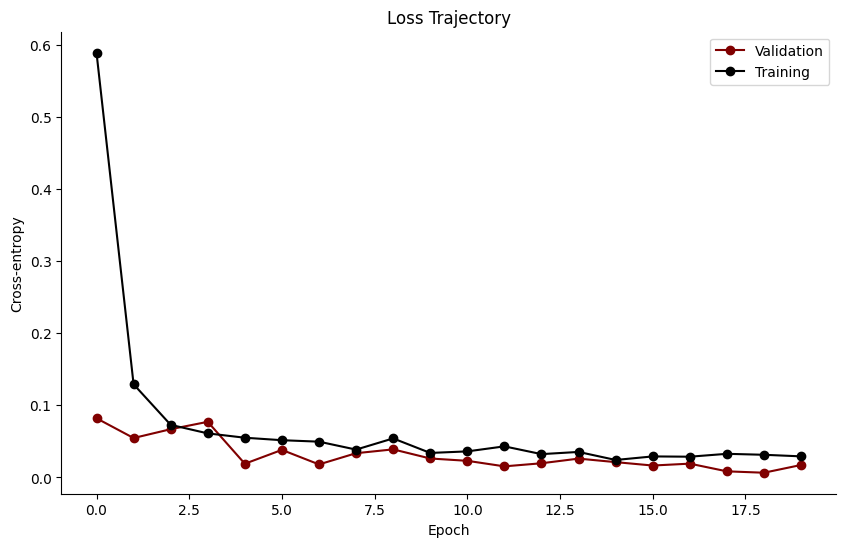

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(EPOCHS), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(EPOCHS), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

### Evaluate Model on Test Data

In [9]:
test_loss, test_accuracy = model.evaluate(test_activations, test_colors)

12/63 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5954 - loss: 1.3251

2025-04-25 14:55:55.585636: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80000000 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6081 - loss: 1.2378


 1/63 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step

2025-04-25 14:55:57.592897: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80000000 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


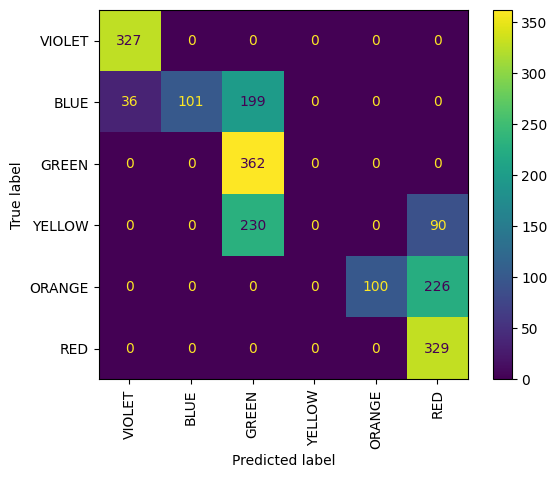

In [10]:
preds = model.predict(test_activations)
metrics.ConfusionMatrixDisplay.from_predictions(
    test_colors, 
    preds.argmax(axis=1),
    display_labels=[c.name for c in Color],
    xticks_rotation="vertical",
)

## Testing on Data from Abnormal Eyes

### "Damanged" Eyes

"Damaged" eyes have a chance for some cells to be dead and never activate.

#### Generating / Loading the Cone Cells for "Damaged" Eyes

In [11]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 10
PROB_DEAD_CELL_STEP = 0.1

NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * PERCENT_RED)
NUM_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    damaged_eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
        PROB_DEAD_CELL = i * PROB_DEAD_CELL_STEP

        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA, PROB_DEAD_CELL) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA, PROB_DEAD_CELL)
        )

        damaged_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    damaged_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/damaged_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            damaged_eyes.append(cone_cells)

#### Testing Model on "Damaged" Eyes

In [12]:
NUM_DATA_POINTS = 100

confusion_data = []
accuracies = []

for cone_cells in damaged_eyes:
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    _, accuracy = model.evaluate(activations, colors)
    accuracies.append(accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6609 - loss: 1.0515 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5653 - loss: 1.4519
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5420 - loss: 1.7658
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4958 - loss: 1.5163
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5184 - loss: 1.8939
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5655 - loss: 1.4050
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5726 - loss: 1.8013
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4046 - loss: 4.5457
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4972 - loss: 3.5371
4/4 ━━━━━

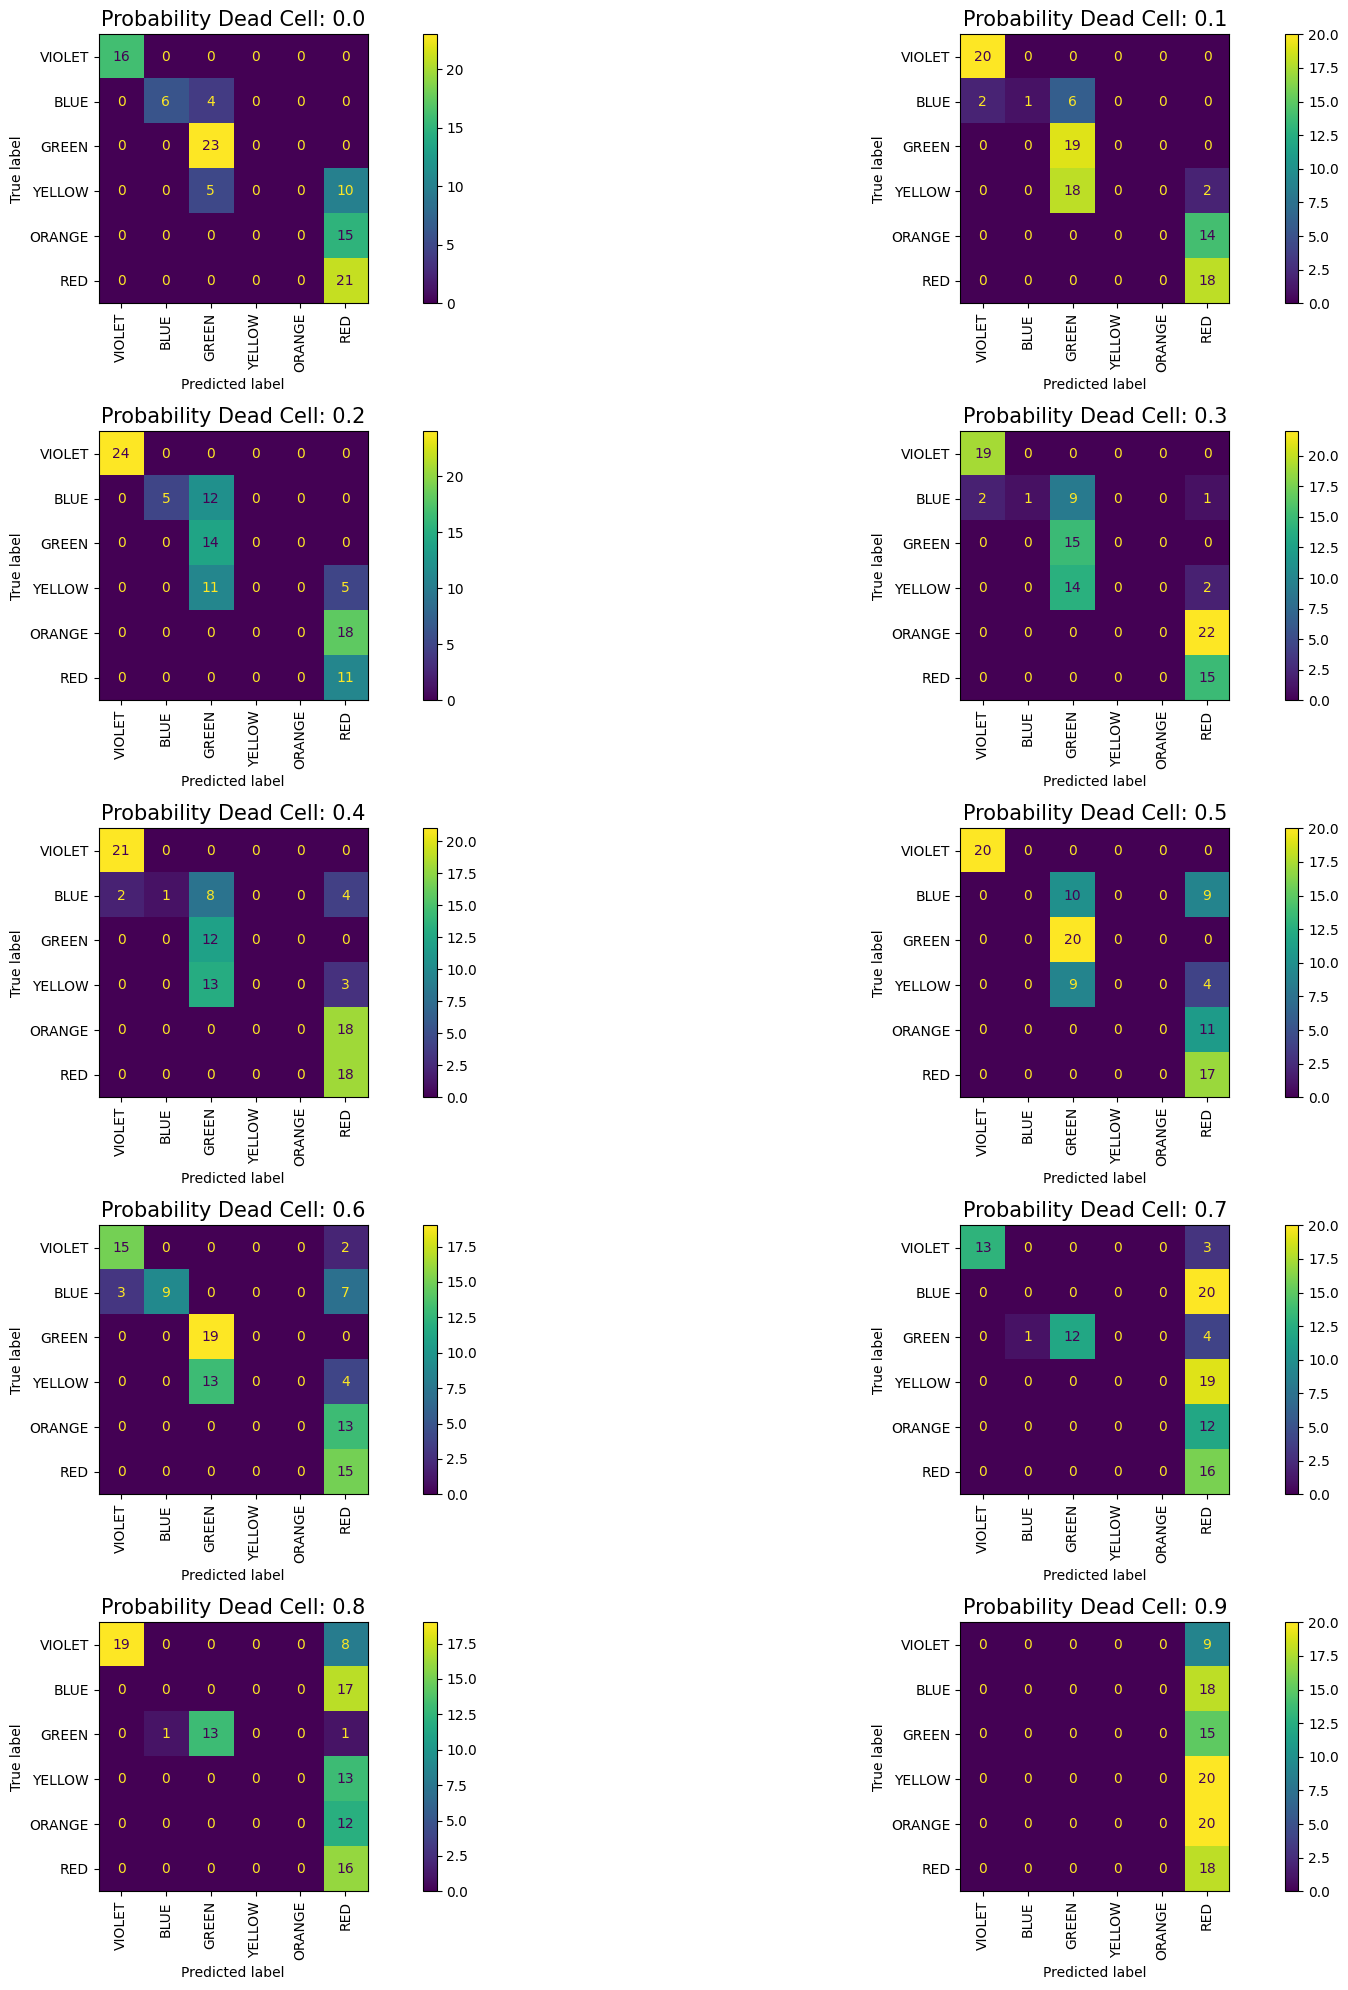

In [13]:
fig, axarr = plt.subplots(5, 2, figsize=(20,20))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    ax.set_title(f"Probability Dead Cell: {PROB_DEAD_CELL_STEP*i:0.1f}", fontsize=15)
    metrics.ConfusionMatrixDisplay.from_predictions(
        colors, 
        preds.argmax(axis=1), 
        ax=ax, 
        display_labels=[c.name for c in Color],
        xticks_rotation="vertical",
    )
fig.tight_layout()

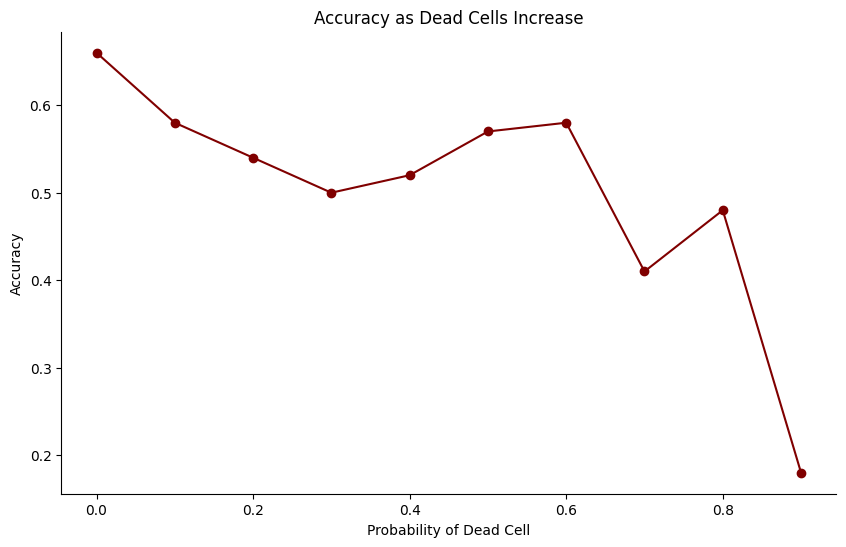

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot([PROB_DEAD_CELL_STEP * i for i in range(NUM_EYES)], accuracies, 'o-', color='maroon')
ax.set_xlabel('Probability of Dead Cell')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as Dead Cells Increase')
sns.despine(ax=ax)

### Colorblind Eyes

Specifically red-green colorblindness

#### Generating / Loading the Cone Cells for Colorblind Eyes

In [15]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 4
NUM_CELLS_PER_EYE = 10000

NUM_RED_GREEN = int(NUM_CELLS_PER_EYE * PERCENT_RED) + int(NUM_CELLS_PER_EYE * PERCENT_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * PERCENT_BLUE)
assert(NUM_RED_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    colorblind_eyes = []

    for i in range(NUM_EYES):
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
    
        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED_GREEN, RED_GREEN_MU, RED_GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        colorblind_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/colorblind_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    colorblind_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/colorblind_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            colorblind_eyes.append(cone_cells)

#### Testing Model on Colorblind Eyes

In [16]:
NUM_DATA_POINTS = 100

confusion_data = []

for cone_cells in colorblind_eyes:
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    model.evaluate(activations, colors)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4366 - loss: 3.6631
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4974 - loss: 3.1086
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3904 - loss: 3.9393
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4609 - loss: 2.9133


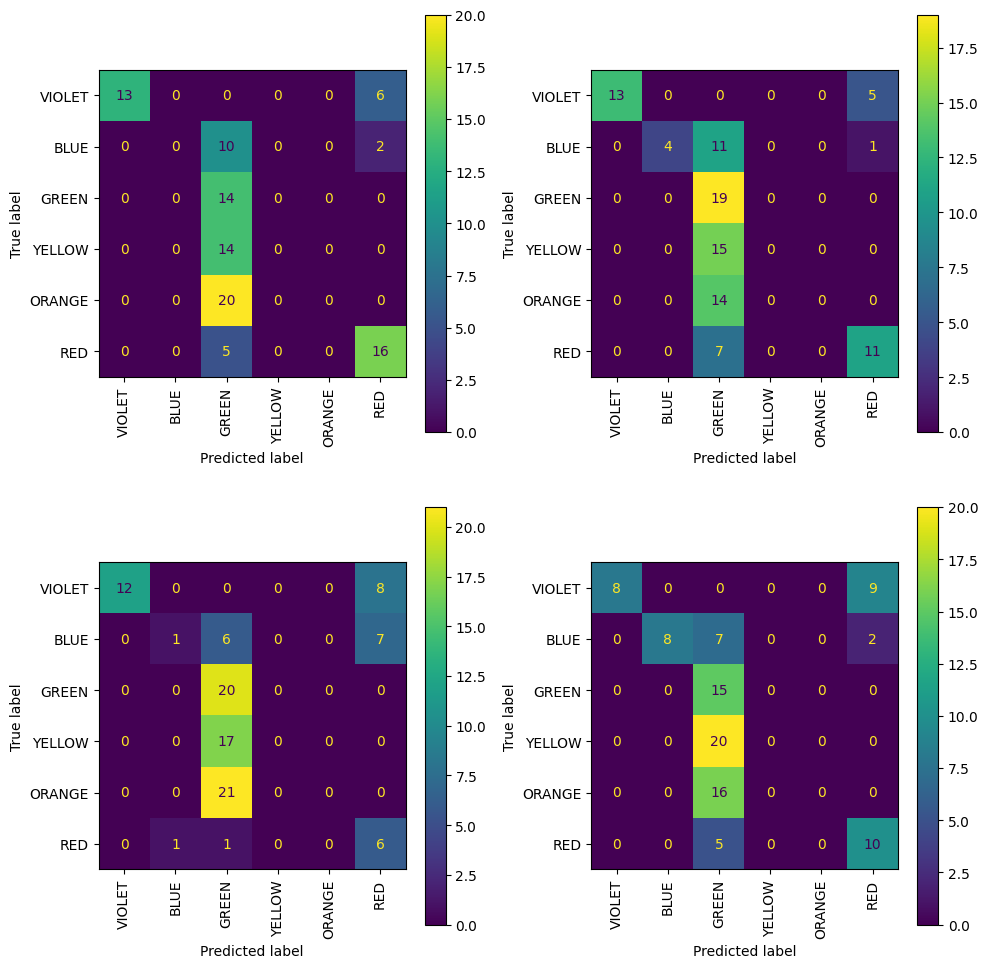

In [17]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    metrics.ConfusionMatrixDisplay.from_predictions(
        colors, 
        preds.argmax(axis=1), 
        ax=ax,
        display_labels=[c.name for c in Color],
        xticks_rotation="vertical",
    )
fig.tight_layout()

### Tetrachromatic Eyes

Tetrachromatic eyes have a fourth type of cell that detects wavelengths between what is detected by the normal red and green cone cells

#### Generating / Loading the Cone Cells for Tetrachromatic Eyes

In [18]:
GENERATE_NEW_CONE_CELLS = False

NUM_EYES = 4
NUM_CELLS_PER_EYE = 10000

NUM_RED = int(NUM_CELLS_PER_EYE * TETRA_RED)
NUM_TETRA = int(NUM_CELLS_PER_EYE * TETRA_PRIME)
NUM_GREEN = int(NUM_CELLS_PER_EYE * TETRA_GREEN)
NUM_BLUE = int(NUM_CELLS_PER_EYE * TETRA_BLUE)
assert(NUM_RED + NUM_TETRA + NUM_GREEN + NUM_BLUE == NUM_CELLS_PER_EYE)

if GENERATE_NEW_CONE_CELLS:

    tetrachromatic_eyes = []

    for i in range(NUM_EYES):
        RED_MU = np.random.uniform(RED_MU_LOWER, RED_MU_UPPER)
        TETRA_MU = np.random.uniform(TETRA_MU_LOWER, TETRA_MU_UPPER)
        GREEN_MU = np.random.uniform(GREEN_MU_LOWER, GREEN_MU_UPPER)
        BLUE_MU = np.random.uniform(BLUE_MU_LOWER, BLUE_MU_UPPER)
    
        # create the cone cells
        cone_cells = (
            generate_cone_cells(NUM_RED, RED_MU, RED_SIGMA) +
            generate_cone_cells(NUM_TETRA, TETRA_MU, TETRA_SIGMA) +
            generate_cone_cells(NUM_GREEN, GREEN_MU, GREEN_SIGMA) +
            generate_cone_cells(NUM_BLUE, BLUE_MU, BLUE_SIGMA)
        )

        tetrachromatic_eyes.append(cone_cells)

        # save the cone cells
        with open(f"./data/tetrachromatic_cone_cells/eye{i:02}.pkl", "wb") as fp:
            pickle.dump(cone_cells, fp, pickle.HIGHEST_PROTOCOL)

else:

    tetrachromatic_eyes = []

    for i in range(NUM_EYES):
        with open(f"./data/tetrachromatic_cone_cells/eye{i:02}.pkl", mode="rb") as fp:
            cone_cells = pickle.load(fp)
            tetrachromatic_eyes.append(cone_cells)

#### Testing Model on Tetrachromatic Eyes

In [19]:
NUM_DATA_POINTS = 100

confusion_data = []

for cone_cells in tetrachromatic_eyes:
    activations, colors = sample_wavelengths(
        num_data_points=NUM_DATA_POINTS, 
        cells=cone_cells, 
    )
    colors = np.array(colors).astype(int)
    preds = model.predict(activations)
    confusion_data.append((colors, preds))
    model.evaluate(activations, colors)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5532 - loss: 1.7620
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4468 - loss: 1.6879
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5799 - loss: 2.0127
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5384 - loss: 1.7032


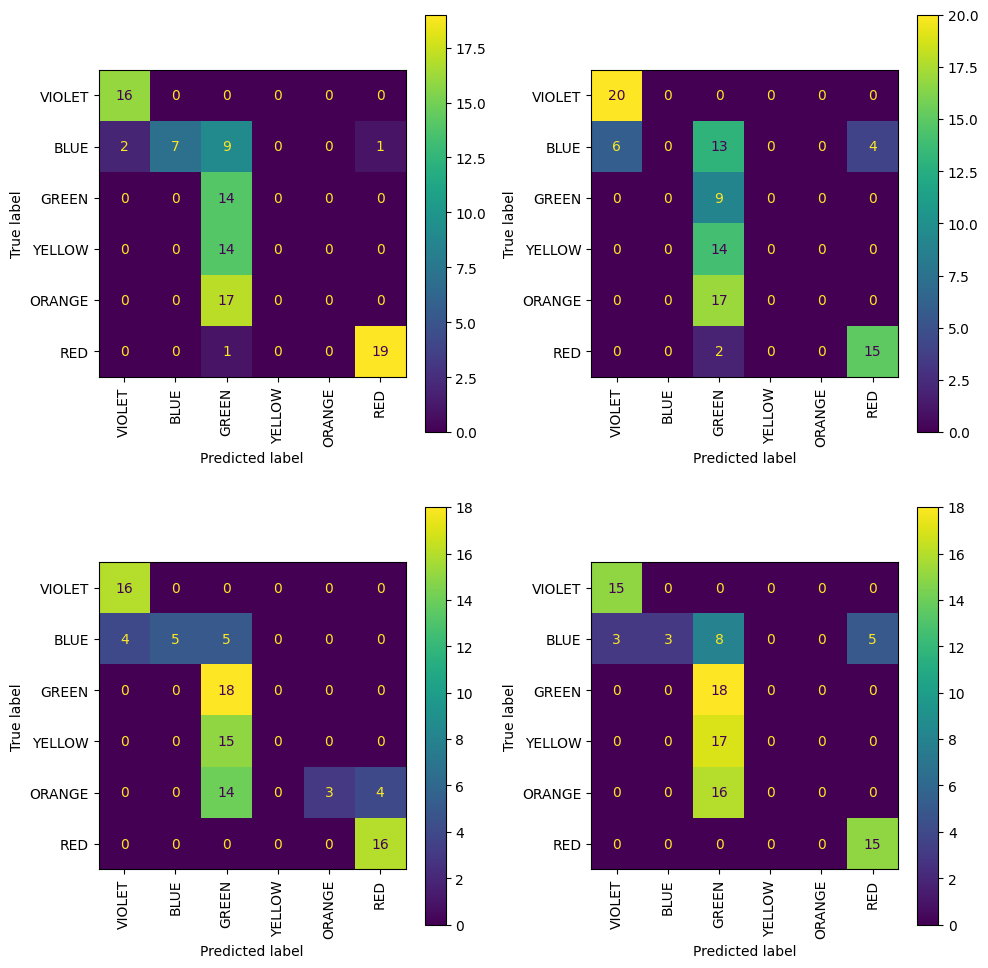

In [20]:
fig, axarr = plt.subplots(2, 2, figsize=(10,10))
for i, ax in enumerate(axarr.flat):
    colors, preds = confusion_data[i]
    metrics.ConfusionMatrixDisplay.from_predictions(
        colors, 
        preds.argmax(axis=1), 
        ax=ax,
        display_labels=[c.name for c in Color],
        xticks_rotation="vertical",
    )
fig.tight_layout()